In [35]:
import pandas as pd
import numpy as np
import datetime

import FinanceDataReader as fdr
import pandas_datareader as pdr

In [128]:
def calculate_momentum(tickers, base_date):
    """ 모든 종목의 1개월 상대모멘텀을 구하고 데이터를 합침 """
    # 월말 데이터 저장
    month_last_df = pd.DataFrame(columns=['Date', 'ticker', '1M_RET'])
    # 종목별 종가 데이터 프레임 생성
    stock_df = pd.DataFrame(columns=['Date', 'ticker', 'Adj Close'])
    
    # 종목별 데이터 준비 및 가공 (합치기)
    for i, ticker in enumerate(tickers):
        price_df, ym_keys = data_preprocessing(ticker, base_date)
        stock_df = stock_df.append(price_df.loc[:,['Date', 'ticker', 'Adj Close']], sort=False)
        
        # 월별 상대 모멘텀 계산을 위한 1개월간 수익률 계산
        for ym in ym_keys:
            m_ret = price_df.loc[price_df[price_df['STD_YM'] == ym].index[-1], 'Adj Close'] / price_df.loc[price_df[price_df['STD_YM'] == ym].index[0], 'Adj Close']
            price_df.loc[price_df['STD_YM'] == ym, ['1M_RET']] = m_ret
            month_last_df = month_last_df.append(price_df.loc[price_df[price_df['STD_YM'] == ym].index[-1], ['Date', 'ticker', 'Adj Close', '1M_RET']])
    
    return month_last_df, stock_df

In [129]:
def data_preprocessing(ticker, base_date):
    """ 데이터 준비 및 초반 작업 """
    df = pdr.get_data_yahoo(ticker, base_date)
    df['Date'] = df.index
    df['ticker'] = ticker
    df.reset_index(drop=True, inplace=True)
    price_df = df.loc[:, ['Date', 'ticker', 'Adj Close']].copy()

    price_df['STD_YM'] = price_df['Date'].map(lambda x : datetime.datetime.strftime(x, '%Y-%m'))
    price_df['1M_RET'] = 0.0
    ym_keys = list(price_df['STD_YM'].unique())

    return price_df, ym_keys

In [130]:
def create_trade_book(sample, sample_codes):
    book = pd.DataFrame()
    book = sample[sample_codes].copy()
    book['STD_YM'] = book.index.map(lambda x : datetime.datetime.strftime(x, '%Y-%m'))
    for c in sample_codes:
        book['p_'+c] = ''
        book['r_'+c] = ''
    return book

In [131]:
def tradings(book, s_codes):
    std_ym = ''
    buy_phase = False
    for s in s_codes:
        print(s)
        for i in book.index:
            if book.loc[i, 'p_'+s] == '' and book.shift(1).loc[i, 'p_'+s] == 'ready_' + s:
                std_ym = book.loc[i, 'STD_YM']
                buy_phase = True
            if book.loc[i, 'p_'+s] == '' and book.loc[i, 'STD_YM'] == std_ym and buy_phase == True:
                book.loc[i, 'p_'+ s] = 'buy_' + s
            if book.loc[i, 'p_'+ s] == '':
                std_ym = None
                buy_phase = False
    return book

In [ ]:
def multi_returns(book, s_codes):
    # 손익 계산
    rtn = 1.0
    buy_dict = {}
    num = len(s_codes)
    sell_dict = {}
    
    for i in book.index:
        for s in s_codes:
            # long 진입
            if book.loc[i, 'p_'+s] == 'buy_' + s and book.shift(1).loc[i, 'p_'+s] == 'ready_'+s and book.shift(2).loc[i, 'p_'+s] == '':
                buy_dict[s] = book.loc[i, s]
            # long 청산
            elif book.loc[i, 'p_'+s] == '' and book.shift(1).loc[i, 'p_'+s] == 'buy_' + s:
                sell_dict[s] = book.loc[i, s]
                # 손익 계산
                rtn = (sell_dict[s] / buy_dict[s]) - 1
                book.loc[i, 'r_'+s] = rtn
                print(f'개별 청산일 : {i}, 종목 코드 : {s}, long 진입가격 : {buy_dict[s]}, long 청산가격 : {sell_dict[s]}, return : {round(rtn*100, 2)}%')
            # 제로 포지션
            if book.loc[i, 'p_'+s] == '':
                buy_dict[s] = 0.0
                sell_dict[s] = 0.0
                
    acc_rtn = 1.0
    for i in book.index:
        rtn = 0.0
        count = 0
        for s in s_codes:
            if book.loc[i, 'p_' + s] == '' and book.shift(1).loc[i, 'p_'+s] == 'buy_'+s:
                count += 1
                rtn += book.loc[i, 'r_'+s]
        if (rtn != 0.0) and (count != 0):
            acc_rtn *= (rtn/count) + 1
            print('')
        book.loc[i, 'acc_rtn']= acc_rtn
        
    print(f'누적 수익률 : {round(acc_rtn, 4)}')

In [156]:
stock = ['AAPL', 'AMZN', 'F']
base_date = '2020-03-01'

month_last_df, stock_df = trading(stock, base_date)
month_last_df

,Date,ticker,1M_RET,Adj Close
21,2020-03-31,AAPL,0.851009,62.531914
42,2020-04-30,AAPL,1.219543,72.247742
62,2020-05-29,AAPL,1.102849,78.395599
84,2020-06-30,AAPL,1.133447,89.950035
106,2020-07-31,AAPL,1.167340,104.803635
...,...,...,...,...
588,2022-06-30,F,0.821402,11.020092
608,2022-07-29,F,1.297703,14.544937
631,2022-08-31,F,1.003389,15.240000
652,2022-09-30,F,0.737327,11.200000


In [169]:
stock_df

,Date,ticker,Adj Close
0,2020-03-02,AAPL,73.479736
1,2020-03-03,AAPL,71.146072
2,2020-03-04,AAPL,74.446159
3,2020-03-05,AAPL,72.031342
4,2020-03-06,AAPL,71.074760
...,...,...,...
649,2022-09-27,F,11.910000
650,2022-09-28,F,12.180000
651,2022-09-29,F,11.470000
652,2022-09-30,F,11.200000


In [133]:
# 2단계 : 상대 모멘텀 수익률로 필터링
#month_ret_df = month_last_df.pivot(index='Date', columns='ticker', values='1M_RET').copy()
month_ret_df = month_last_df.pivot('Date', 'ticker', '1M_RET').copy()

month_ret_df = month_ret_df.rank(axis=1, ascending=False, method="max", pct=True)

In [134]:
month_ret_df = month_ret_df.where(month_ret_df < 0.4, np.nan)
month_ret_df.fillna(0, inplace=True)
month_ret_df[month_ret_df != 0] = 1
month_ret_df
stock_df

,Date,ticker,Adj Close
0,2020-03-02,AAPL,73.479744
1,2020-03-03,AAPL,71.146072
2,2020-03-04,AAPL,74.446159
3,2020-03-05,AAPL,72.031349
4,2020-03-06,AAPL,71.074760
...,...,...,...
649,2022-09-27,F,11.910000
650,2022-09-28,F,12.180000
651,2022-09-29,F,11.470000
652,2022-09-30,F,11.200000


In [167]:
# 3단계 : 신호 목록으로 트레이딩 + 포지셔닝
sig_dict = dict()
for date in month_ret_df.index:
    ticker_list = list(month_ret_df.loc[date, month_ret_df.loc[date,:] >= 1.0].index)
    sig_dict[date] = ticker_list
    
stock_c_matrix = stock_df.pivot('Date', 'ticker', 'Adj Close').copy()
book = create_trade_book(stock_c_matrix, list(stock_df['ticker'].unique()))

# 포지셔닝
for date, values in sig_dict.items():
    print(date, values)
    for stock in values:
        book.loc[date, 'p_'+ stock] = 'ready_' + stock
        
book = tradings(book, stocks)

2020-03-31 00:00:00 ['AMZN']
2020-04-30 00:00:00 ['AMZN']
2020-05-29 00:00:00 ['F']
2020-06-30 00:00:00 ['AAPL']
2020-07-31 00:00:00 ['AAPL']
2020-08-31 00:00:00 ['AAPL']
2020-09-30 00:00:00 ['F']
2020-10-30 00:00:00 ['F']
2020-11-30 00:00:00 ['F']
2020-12-31 00:00:00 ['AAPL']
2021-01-29 00:00:00 ['F']
2021-02-26 00:00:00 ['F']
2021-03-31 00:00:00 ['F']
2021-04-30 00:00:00 ['AMZN']
2021-05-28 00:00:00 ['F']
2021-06-30 00:00:00 ['AAPL']
2021-07-30 00:00:00 ['AAPL']
2021-08-31 00:00:00 ['AAPL']
2021-09-30 00:00:00 ['F']
2021-10-29 00:00:00 ['F']
2021-11-30 00:00:00 ['AAPL']
2021-12-31 00:00:00 ['AAPL']
2022-01-31 00:00:00 ['AAPL']
2022-02-28 00:00:00 ['AMZN']
2022-03-31 00:00:00 ['AMZN']
2022-04-29 00:00:00 ['AAPL']
2022-05-31 00:00:00 ['AMZN']
2022-06-30 00:00:00 ['AAPL']
2022-07-29 00:00:00 ['F']
2022-08-31 00:00:00 ['F']
2022-09-30 00:00:00 ['AMZN']
2022-10-03 00:00:00 []
AAPL
AMZN
F


In [168]:
book

ticker,AAPL,AMZN,F,STD_YM,p_AAPL,r_AAPL,p_AMZN,r_AMZN,p_F,r_F
Date,,,,,,,,,,
2020-03-02,73.479736,97.697502,7.010261,2020-03,,,,,,
2020-03-03,71.146072,95.449501,6.786322,2020-03,,,,,,
2020-03-04,74.446159,98.791496,6.893423,2020-03,,,,,,
2020-03-05,72.031342,96.201500,6.562383,2020-03,,,,,,
2020-03-06,71.074760,95.054497,6.318971,2020-03,,,,,,
...,...,...,...,...,...,...,...,...,...,...
2022-09-27,151.759995,114.410004,11.910000,2022-09,,,,,buy_F,
2022-09-28,149.839996,118.010002,12.180000,2022-09,,,,,buy_F,
2022-09-29,142.479996,114.800003,11.470000,2022-09,,,,,buy_F,


# PAA 코드 테스트

In [248]:
# 필요 라이브러리 import
import pandas_datareader as pdr
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import math
import quantstats as qs

# pandas 설정 및 메타데이터 세팅
pd.options.display.float_format = '{:.4f}'.format
pd.set_option('display.max_columns', None)

start_day = datetime(2010,1,1) # 시작일
end_day = datetime(2022,9,30) # 종료일

# RU : Risky Universe
# CU : Cash Universe
RU = ['SPY', 'QQQ', 'IWM', 'VGK', 'EWJ', 'EEM', 'VNQ', 'GLD', 'DBC', 'HYG', 'LQD', 'TLT']
CU = ['IEF']

# 데이터 추출 함수
def get_price_data(RU, CU):
    df_RCU = pd.DataFrame(columns=RU+CU)
    
    for ticker in RU + CU:
        df_RCU[ticker] = pdr.get_data_yahoo(ticker, start_day - timedelta(days=365), end_day)['Adj Close']  
    
    return df_RCU

# 각 자산 군의 데이터 추출
df_RCU = get_price_data(RU, CU)

# 모멘텀 지수 계산 함수
def get_momentum(x):
    temp_list = [0 for i in range(len(x.index))]
    momentum = pd.Series(temp_list, index=x.index)

    try:   
        before12 = df_RCU[x.name-timedelta(days=370):x.name-timedelta(days=365)].iloc[-1][RU+CU]
        momentum = (x / before12 - 1)
    except Exception as e:
        #print("Error : ", str(e))
        pass
    
    return momentum

# 각 자산별 모멘텀 지수 계산
mom_col_list = [col+'_M' for col in df_RCU[RU+CU].columns]
df_RCU[mom_col_list] = df_RCU.apply(lambda x: get_momentum(x), axis=1)

In [249]:
# 12개월 이평선
mom_col_list = [col+'_12M' for col in df_RCU[RU+CU].columns]
df_RCU[mom_col_list] = df_RCU[RU+CU].rolling(window=240).mean()
df_RCU.fillna(0)

# 백테스트할 기간 데이터 추출
df_RCU = df_RCU[start_day:end_day]

# 매월 말일 데이터만 추출(리밸런싱에 사용)
df_RCU = df_RCU.resample(rule='M').last()

In [250]:
# 하락추세 자산 갯수 측정, 안전자산 비중 측정
def count_decrease_asset(x):
    asset = pd.Series([0, 0, 0], index=['D_CNT_ASSET', 'ASSET', 'RATIO'])
    
    # 하락 추세 자산 갯수 계산
    decrease_asset = [1 if x[ticker] < x[ticker+'_12M'] else 0 for ticker in x.index[:12]]
    
    # 안전 자산 비중 계산
    ratio =  sum(decrease_asset) / 6
    ratio = 1 if ratio >= 1 else ratio

    asset['D_CNT_ASSET'] = sum(decrease_asset)
    asset['ASSET'] = 'IEF'
    asset['RATIO'] = ratio
    
    return asset

# 매월 선택할 자산과 가격
df_RCU[['D_CNT_ASSET','ASSET','PRICE']] = df_RCU.apply(lambda x: count_decrease_asset(x), axis=1)

In [251]:
# 모멘텀 지수 계산 함수
def get_momentum_upper(x):
    asset = pd.Series([0, 0, 0, 0, 0, 0], index=['RANK1', 'RANK2', 'RANK3', 'RANK4', 'RANK5', 'RANK6'])
    
    momentum_cols = [ticker + '_M' for ticker in RU]
    select_momentum = x[momentum_cols].sort_values(ascending=False).index
    
    asset['RANK1'] = select_momentum[0][:3]
    asset['RANK2'] = select_momentum[1][:3]
    asset['RANK3'] = select_momentum[2][:3]
    asset['RANK4'] = select_momentum[3][:3]
    asset['RANK5'] = select_momentum[4][:3]
    asset['RANK6'] = select_momentum[5][:3]
    
    return asset

# 모멘텀 상위 6개 자산군 구하기
df_RCU[['RANK1', 'RANK2', 'RANK3', 'RANK4', 'RANK5', 'RANK6']] = df_RCU.apply(lambda x: get_momentum_upper(x), axis=1)

# 각 자산별 수익률 계산
profit_col_list = [col+'_P' for col in df_RCU[RU+CU].columns]
df_RCU[profit_col_list] = df_RCU[RU+CU].pct_change() * 100

In [252]:
# 매월 수익률 & 누적 수익률 계산
df_RCU['PROFIT'] = 0

for i in range(len(df_RCU)):
    profit = 0
    log_profit = 0
        
    if i != 0:
        CU_ratio = df_RCU.iloc[i-1]['PRICE']
        RU_ratio = (1- CU_ratio)/ 6
        
        profit1 = df_RCU[df_RCU.iloc[i-1]['ASSET'] + '_P'].iloc[i] * CU_ratio
        profit2 = df_RCU[df_RCU.iloc[i-1]['RANK1'] + '_P'].iloc[i] * RU_ratio
        profit3 = df_RCU[df_RCU.iloc[i-1]['RANK2'] + '_P'].iloc[i] * RU_ratio
        profit4 = df_RCU[df_RCU.iloc[i-1]['RANK3'] + '_P'].iloc[i] * RU_ratio
        profit5 = df_RCU[df_RCU.iloc[i-1]['RANK4'] + '_P'].iloc[i] * RU_ratio
        profit6 = df_RCU[df_RCU.iloc[i-1]['RANK5'] + '_P'].iloc[i] * RU_ratio
        profit7 = df_RCU[df_RCU.iloc[i-1]['RANK6'] + '_P'].iloc[i] * RU_ratio
        
        profit = profit1 + profit2 + profit3 + profit4 + profit5 + profit6 + profit7
        
        print('='*30)
        print(f'CU_ratio : {CU_ratio}')
        print(f'RU_ratio : {RU_ratio}')
        print(f'profit1 : {profit1}')
        print(f'profit2 : {profit2}')
        print(f'profit3 : {profit3}')
        print(f'profit4 : {profit4}')
        print(f'profit5 : {profit5}')
        print(f'profit6 : {profit6}')
        print(f'profit7 : {profit7}')
        print(f'profit : {profit}')
    
    df_RCU.loc[df_RCU.index[i], 'PROFIT'] = profit

# QuantStats의 기본 리포트
#qs.reports.basic(df_RCU['PROFIT']/100)

CU_ratio : 0.16666666666666666
RU_ratio : 0.1388888888888889
profit1 : 0.055294920875322465
profit2 : 0.2467221965040678
profit3 : 0.6394294526979347
profit4 : 0.7754358457829933
profit5 : -0.07641499996825477
profit6 : 0.6215472230914436
profit7 : 0.4332586387406295
profit : 2.6952732777241364
CU_ratio : 0.16666666666666666
RU_ratio : 0.1388888888888889
profit1 : -0.17613365888115942
profit2 : 1.4148306369000077
profit3 : 1.1265148645075502
profit4 : 1.0709619374981254
profit5 : 1.1431476085593837
profit6 : 0.9035937973524515
profit7 : 0.8455494312757291
profit : 6.328464617212088
CU_ratio : 0.16666666666666666
RU_ratio : 0.1388888888888889
profit1 : 0.27545554582484677
profit2 : 0.9930733308327395
profit3 : -0.023078793572402688
profit4 : 0.7886775308472828
profit5 : 0.3114641714974973
profit6 : -0.5280914048832803
profit7 : 0.2148626938316103
profit : 2.0323630743782934
CU_ratio : 0.0
RU_ratio : 0.16666666666666666
profit1 : 0.0
profit2 : -0.8890975902473507
profit3 : -1.25610176289

CU_ratio : 0.6666666666666666
RU_ratio : 0.05555555555555556
profit1 : -0.3456933393439998
profit2 : -0.008949882998999915
profit3 : 0.30551376843443756
profit4 : 0.22695799383095383
profit5 : -0.11061509970998197
profit6 : 0.05478892443066726
profit7 : 0.024244237874988035
profit : 0.14624660251806498
CU_ratio : 0.3333333333333333
RU_ratio : 0.11111111111111112
profit1 : 1.0162004271964489
profit2 : 0.015365051401997992
profit3 : -0.9139080179669566
profit4 : -0.7085697207438766
profit5 : 0.18339588344665636
profit6 : -0.21485380645233212
profit7 : 0.7599086406490541
profit : 0.13753845753099203
CU_ratio : 1.0
RU_ratio : 0.0
profit1 : 1.2171245132168496
profit2 : 0.0
profit3 : 0.0
profit4 : 0.0
profit5 : 0.0
profit6 : 0.0
profit7 : 0.0
profit : 1.2171245132168496
CU_ratio : 0.16666666666666666
RU_ratio : 0.1388888888888889
profit1 : 0.006376214709905939
profit2 : 0.03528227263343811
profit3 : 0.001043727670830953
profit4 : 0.23677633858167224
profit5 : 0.035619173465299844
profit6 : 0

                    Strategy
------------------  ----------
Start Period        2010-01-31
End Period          2022-09-30
Risk-Free Rate      0.0%
Time in Market      100.0%

Cumulative Return   90.63%
CAGR﹪              5.22%

Sharpe              3.39
Prob. Sharpe Ratio  99.41%
Sortino             5.38
Sortino/√2          3.8
Omega               1.8

Max Drawdown        -18.32%
Longest DD Days     457

Gain/Pain Ratio     0.8
Gain/Pain (1M)      0.8

Payoff Ratio        1.05
Profit Factor       1.8
Common Sense Ratio  2.32
CPC Index           1.19
Tail Ratio          1.29
Outlier Win Ratio   3.48
Outlier Loss Ratio  2.97

MTD                 -4.73%
3M                  -6.51%
6M                  -13.57%
YTD                 -17.08%
1Y                  -18.32%
3Y (ann.)           -0.43%
5Y (ann.)           3.68%
10Y (ann.)          4.29%
All-time (ann.)     5.22%

Avg. Drawdown       -3.75%
Avg. Drawdown Days  177
Recovery Factor     4.95
Ulcer Index         0.04
Serenity Index      6.43

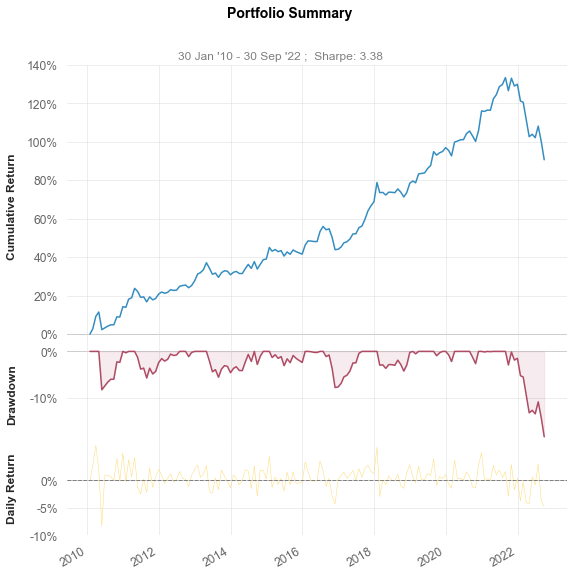

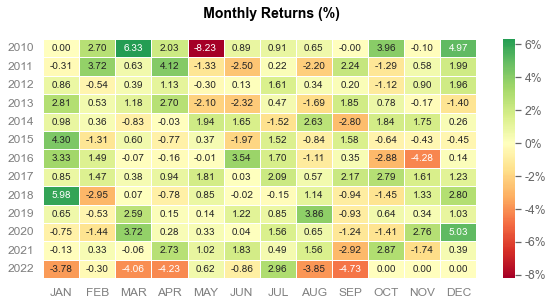

In [253]:
qs.reports.basic(df_RCU['PROFIT']/100)

In [254]:
df_RCU.tail(11)

,SPY,QQQ,IWM,VGK,EWJ,EEM,VNQ,GLD,DBC,HYG,LQD,TLT,IEF,SPY_M,QQQ_M,IWM_M,VGK_M,EWJ_M,EEM_M,VNQ_M,GLD_M,DBC_M,HYG_M,LQD_M,TLT_M,IEF_M,SPY_12M,QQQ_12M,IWM_12M,VGK_12M,EWJ_12M,EEM_12M,VNQ_12M,GLD_12M,DBC_12M,HYG_12M,LQD_12M,TLT_12M,IEF_12M,D_CNT_ASSET,ASSET,PRICE,RANK1,RANK2,RANK3,RANK4,RANK5,RANK6,SPY_P,QQQ_P,IWM_P,VGK_P,EWJ_P,EEM_P,VNQ_P,GLD_P,DBC_P,HYG_P,LQD_P,TLT_P,IEF_P,PROFIT
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-11-30,448.7692,391.3750,215.3978,63.1764,64.8394,47.7192,103.3855,165.5000,19.4800,81.9493,129.6898,148.8330,114.1759,0.2760,0.3214,0.2168,0.1742,0.0418,0.0171,0.3161,-0.0070,0.3974,0.0343,-0.0166,-0.0383,-0.0305,412.0445,344.8495,218.3815,63.1236,67.0558,51.7740,94.9873,168.7254,18.3460,82.0822,128.8054,141.5920,113.8675,5,IEF,0.8333,DBC,QQQ,VNQ,SPY,IWM,VGK,-0.8035,1.9968,-4.3324,-4.8904,-3.0263,-4.0848,-2.1093,-0.6901,-8.7588,-1.1690,-0.1186,2.7715,1.0921,-1.7357
2021-12-31,469.5238,395.8849,220.2905,66.4605,66.3158,48.4384,113.4197,170.9600,20.7800,83.8212,129.6455,145.8358,113.5776,0.2873,0.2742,0.1454,0.1689,0.0116,-0.0363,0.4054,-0.0415,0.4136,0.0376,-0.0184,-0.0460,-0.0333,420.7796,352.2905,220.0228,63.7764,67.1256,51.5047,97.6496,167.9318,18.8350,82.3346,128.7253,141.3567,113.6229,2,IEF,0.3333,DBC,VNQ,SPY,QQQ,VGK,IWM,4.6248,1.1523,2.2715,5.1983,2.2770,1.5071,9.7056,3.2991,6.6735,2.2842,-0.0341,-2.0138,-0.5241,0.3862
2022-01-31,444.7605,361.2568,199.2865,64.0841,63.4635,48.4285,103.8679,168.0900,22.4200,81.5958,124.9887,140.1280,111.1777,0.2319,0.1597,-0.0117,0.1373,-0.0237,-0.0662,0.2866,-0.0262,0.4760,0.0138,-0.0360,-0.0488,-0.0433,427.0310,355.8706,219.4038,64.3685,66.9225,50.9936,99.5521,167.7748,19.3309,82.4595,128.4571,140.9371,113.2520,7,IEF,1.0000,DBC,VNQ,SPY,QQQ,VGK,HYG,-5.2741,-8.7470,-9.5347,-3.5756,-4.3011,-0.0205,-8.4217,-1.6788,7.8922,-2.6549,-3.5919,-3.9139,-2.1130,-3.7778
2022-02-28,431.6325,345.0871,201.3463,60.6949,62.3344,46.3362,100.2505,178.3800,23.8700,80.8949,122.3246,137.8397,110.8396,0.1632,0.1093,-0.0598,0.0501,-0.0584,-0.1135,0.2006,0.1024,0.4268,0.0076,-0.0347,-0.0074,-0.0231,431.6969,358.7755,217.7396,64.7140,66.6262,50.6068,100.8642,168.6068,19.8079,82.4502,128.2005,140.9944,113.0190,10,IEF,1.0000,DBC,VNQ,SPY,QQQ,GLD,VGK,-2.9517,-4.4760,1.0336,-5.2888,-1.7790,-4.3202,-3.4827,6.1217,6.4674,-0.8590,-2.1315,-1.6330,-0.3041,-0.3041
2022-03-31,447.8577,361.1953,203.6769,60.7905,61.0172,44.7695,106.5301,180.6500,26.0600,79.8536,118.7849,130.3351,106.3384,0.1546,0.1415,-0.0620,0.0180,-0.0823,-0.1372,0.2133,0.1293,0.5689,-0.0173,-0.0486,-0.0095,-0.0398,435.5088,360.6503,216.1085,64.5496,65.9739,49.8528,102.2034,170.4577,20.6965,82.2938,127.6013,140.8399,112.6997,7,IEF,1.0000,DBC,VNQ,SPY,QQQ,GLD,VGK,3.7590,4.6679,1.1575,0.1575,-2.1131,-3.3811,6.2639,1.2726,9.1747,-1.2871,-2.8938,-5.4444,-4.0609,-4.0609
2022-04-30,408.5497,312.0882,183.5146,56.9935,56.0752,42.0229,102.1753,176.9100,27.5300,76.5155,110.8272,118.0525,101.8422,-0.0063,-0.0749,-0.1810,-0.1027,-0.1507,-0.2139,0.0832,0.0643,0.5244,-0.0648,-0.1197,-0.1226,-0.0888,437.7683,361.4875,214.1722,64.2320,65.3137,49.1141,103.3803,171.3991,21.4465,82.0003,126.5924,139.7751,111.9409,10,IEF,1.0000,DBC,VNQ,GLD,SPY,HYG,QQQ,-8.7769,-13.5957,-9.8992,-6.2460,-8.0993,-6.1351,-4.0878,-2.0703,5.6408,-4.1803,-6.6993,-9.4239,-4.2283,-4.2283
2022-05-31,409.4719,307.1366,183.8718,58.3698,57.0458,42.2807,97.3880,171.1400,28.8000,77.7626,112.8929,115.3925,102.4720,-0.0040,-0.0724,-0.1704,-0.1069,-0.1428,-0.2079,0.0201,-0.0406,0.5484,-0.0495,-0.1107,-0.1444,-0.0878,436.7713,358.6921,210.3327,63.4012,64.3838,48.0045,103.2445,171.0840,22.2575,81.4626,125.1435,137.9962,111.0129,10,IEF,1.0000,DBC,VNQ,SPY,GLD,HYG,QQQ,0.2257,-1.5866,0.1946,2.4148,1.7308,0.6135,-4.6854,-3.2615,4.6131,1.6299,1.8639,-2.2533,0.6184,0.6184
2022-06-30,375.7067,279.7772,168.4884,52.5924,52.8300,40.1000,90.1337,168.4600,26.6400,72.2805,108.8030,113.9217,101.5872,-0.1062,-0.2048,-0.2537,-0.1841,-0.1998,-0.2558,-0.0801,0.0171,0.3839,-0.1280,-0.1614,-0.191

# DAA 코드 테스트

In [31]:
# 필요 라이브러리 import
import pandas_datareader as pdr
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import math
import quantstats as qs

# pandas 설정 및 메타데이터 세팅
pd.options.display.float_format = '{:.4f}'.format
pd.set_option('display.max_columns', None)

start_day = datetime(2010,1,1) # 시작일
end_day = datetime(2022,9,30) # 종료일

# RU : Risky Universe
# DU : Defence Universe
# CU : Canaria Universe
RU = ['SPY', 'QQQ', 'IWM', 'VGK', 'EWJ', 'EEM', 'VNQ', 'GLD', 'DBC', 'HYG', 'LQD', 'TLT']
DU = ['LQD','SHY','IEF']
CU = ['VWO', 'BND']
TU = list(set(RU+DU+CU)) # LQD 중복 제거

# 데이터 추출 함수
def get_price_data(TU, CU):
    df_TU = pd.DataFrame(columns=TU)
    df_CU = pd.DataFrame(columns=CU)
    
    for ticker in TU:
        df_TU[ticker] = pdr.get_data_yahoo(ticker, start_day - timedelta(days=365), end_day)['Adj Close']  
    
    for ticker in CU:
        df_CU[ticker] = pdr.get_data_yahoo(ticker, start_day - timedelta(days=365), end_day)['Adj Close']  
     
    return df_TU, df_CU

# 각 자산 군의 데이터 추출
df_TU, df_CU = get_price_data(TU, CU)

# 모멘텀 지수 계산 함수
def get_momentum(x):
    temp_list = [0 for i in range(len(x.index))]
    momentum = pd.Series(temp_list, index=x.index)

    try:
        before1 = df_TU[x.name-timedelta(days=35):x.name-timedelta(days=30)].iloc[-1][TU]
        before3 = df_TU[x.name-timedelta(days=95):x.name-timedelta(days=90)].iloc[-1][TU]        
        before6 = df_TU[x.name-timedelta(days=185):x.name-timedelta(days=180)].iloc[-1][TU]        
        before12 = df_TU[x.name-timedelta(days=370):x.name-timedelta(days=365)].iloc[-1][TU]

        momentum = 12 * (x / before1 - 1) + 4 * (x / before3 - 1) + 2 * (x / before6 - 1) + (x / before12 - 1)
    except Exception as e:
        #print("Error : ", str(e))
        pass
    
    return momentum

# 각 자산별 모멘텀 지수 계산
mom_col_list = [col+'_M' for col in df_TU[TU].columns]
df_TU[mom_col_list] = df_TU[TU].apply(lambda x: get_momentum(x), axis=1)

# 백테스트할 기간 데이터 추출
df_TU = df_TU[start_day:end_day]

# 매월 말일 데이터만 추출(리밸런싱에 사용)
df_TU = df_TU.resample(rule='M').last()

# 카나리아를 통한 안전자산 비중 측정
def get_canaria_ratio(x):
    asset = pd.Series([0, 0.0], index=['MMT_ASSET', 'RATIO'])
    
    # 모멘텀 > 0 갯수 계산
    momentum_asset = [1 if x[ticker+'_M'] > 0 else 0 for ticker in CU]
    
    # 공격 자산 비중 계산
    ratio =  float(sum(momentum_asset) / 2)

    asset['MMT_ASSET'] = int(sum(momentum_asset))
    asset['RATIO'] = round(ratio, 2)
    
    return asset

# 매월 선택할 자산과 가격
df_TU[['MMT_ASSET', 'RATIO']] = df_TU.apply(lambda x: get_canaria_ratio(x), axis=1)

In [32]:
# 모멘텀 지수 계산 함수
def get_momentum_RU(x):
    asset = pd.Series([0, 0, 0, 0, 0, 0], index=['RRANK1', 'RRANK2', 'RRANK3', 'RRANK4', 'RRANK5', 'RRANK6'])
    
    momentum_cols = [ticker + '_M' for ticker in RU]
    select_momentum = x[momentum_cols].sort_values(ascending=False).index
    
    asset['RRANK1'] = select_momentum[0][:3]
    asset['RRANK2'] = select_momentum[1][:3]
    asset['RRANK3'] = select_momentum[2][:3]
    asset['RRANK4'] = select_momentum[3][:3]
    asset['RRANK5'] = select_momentum[4][:3]
    asset['RRANK6'] = select_momentum[5][:3]
    
    return asset

# 모멘텀 지수 계산 함수
def get_momentum_DU(x):
    asset = pd.Series([0, 0, 0], index=['DRANK1', 'DRANK2', 'DRANK3'])
    
    momentum_cols = [ticker + '_M' for ticker in DU]
    select_momentum = x[momentum_cols].sort_values(ascending=False).index

    asset['DRANK1'] = select_momentum[0][:3]
    asset['DRANK2'] = select_momentum[1][:3]
    asset['DRANK3'] = select_momentum[2][:3]
    
    return asset


# 공격자산 모멘텀 상위 6개 자산군 구하기
df_TU[['RRANK1', 'RRANK2', 'RRANK3', 'RRANK4', 'RRANK5', 'RRANK6']] = df_TU.apply(lambda x : get_momentum_RU(x), axis=1)

# 방어자산 모멘텀 상위 3개 자산구하기
df_TU[['DRANK1', 'DRANK2', 'DRANK3']] = df_TU.apply(lambda x : get_momentum_DU(x), axis=1)

# 각 자산별 수익률 계산
profit_col_list = [col+'_P' for col in df_TU[TU].columns]
df_TU[profit_col_list] = df_TU[TU].pct_change() * 100

# 매월 수익률 & 누적 수익률 계산
df_TU['PROFIT'] = 0

for i in range(len(df_TU)):
    profit = 0
    log_profit = 0
        
    if i != 0:
        RU_ratio = df_TU.iloc[i-1]['RATIO']
        DU_ratio = (1.0 - RU_ratio)
        
        profit1 = df_TU[df_TU.iloc[i-1]['DRANK1'] + '_P'].iloc[i] * DU_ratio
        profit2 = df_TU[df_TU.iloc[i-1]['RRANK1'] + '_P'].iloc[i] * (RU_ratio/6)
        profit3 = df_TU[df_TU.iloc[i-1]['RRANK2'] + '_P'].iloc[i] * (RU_ratio/6)
        profit4 = df_TU[df_TU.iloc[i-1]['RRANK3'] + '_P'].iloc[i] * (RU_ratio/6)
        profit5 = df_TU[df_TU.iloc[i-1]['RRANK4'] + '_P'].iloc[i] * (RU_ratio/6)
        profit6 = df_TU[df_TU.iloc[i-1]['RRANK5'] + '_P'].iloc[i] * (RU_ratio/6)
        profit7 = df_TU[df_TU.iloc[i-1]['RRANK6'] + '_P'].iloc[i] * (RU_ratio/6)
        
        profit = profit1 + profit2 + profit3 + profit4 + profit5 + profit6 + profit7
        
        print('='*30)
        print(f'RU_ratio : {RU_ratio}')
        print(f'DU_ratio : {DU_ratio}')
        print(f'drank1 : {df_TU[df_TU.iloc[i]["DRANK1"] + "_P"].name }')
        print(f'profit1 : {profit1}')
        print(f'profit2 : {profit2}')
        print(f'profit3 : {profit3}')
        print(f'profit4 : {profit4}')
        print(f'profit5 : {profit5}')
        print(f'profit6 : {profit6}')
        print(f'profit7 : {profit7}')
        print(f'profit : {profit}')
        

    
    df_TU.loc[df_TU.index[i], 'PROFIT'] = profit

                    Strategy
------------------  ----------
Start Period        2010-01-31
End Period          2022-09-30
Risk-Free Rate      0.0%
Time in Market      100.0%

Cumulative Return   167.1%
CAGR﹪              8.06%

Sharpe              4.88
Prob. Sharpe Ratio  99.99%
Sortino             8.75
Sortino/√2          6.19
Omega               2.28

Max Drawdown        -14.77%
Longest DD Days     397

Gain/Pain Ratio     1.28
Gain/Pain (1M)      1.28

Payoff Ratio        1.19
Profit Factor       2.28
Common Sense Ratio  3.07
CPC Index           1.78
Tail Ratio          1.35
Outlier Win Ratio   3.59
Outlier Loss Ratio  3.29

MTD                 -1.19%
3M                  -5.71%
6M                  -6.94%
YTD                 -11.14%
1Y                  -14.77%
3Y (ann.)           5.82%
5Y (ann.)           7.17%
10Y (ann.)          7.44%
All-time (ann.)     8.06%

Avg. Drawdown       -2.96%
Avg. Drawdown Days  114
Recovery Factor     11.31
Ulcer Index         0.03
Serenity Index      

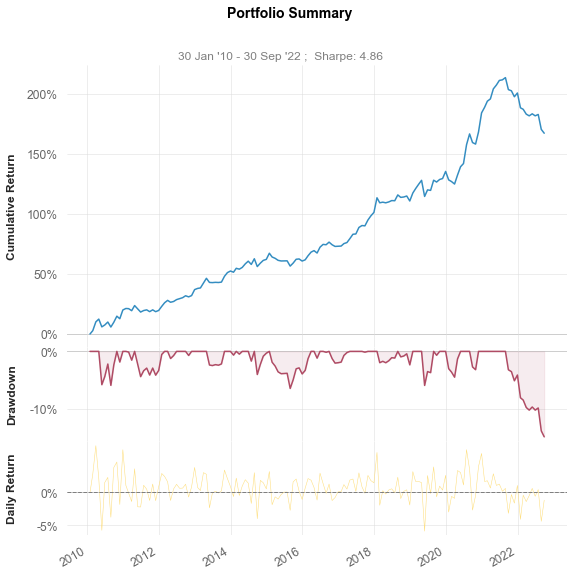

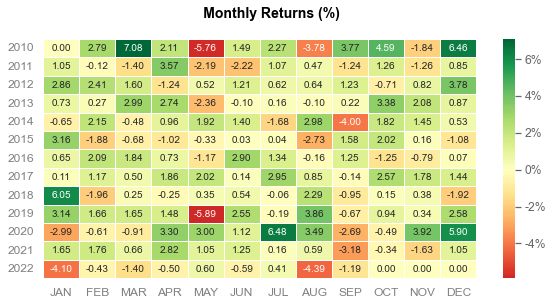

In [38]:
# QuantStats의 기본 리포트
qs.reports.basic(df_TU['PROFIT']/100)

In [270]:
df_TU

,VWO,LQD,EEM,QQQ,VNQ,TLT,GLD,BND,VGK,SPY,SHY,IEF,HYG,DBC,EWJ,IWM,VWO_M,LQD_M,EEM_M,QQQ_M,VNQ_M,TLT_M,GLD_M,BND_M,VGK_M,SPY_M,SHY_M,IEF_M,HYG_M,DBC_M,EWJ_M,IWM_M,MMT_ASSET,RATIO,RRANK1,RRANK2,RRANK3,RRANK4,RRANK5,RRANK6,DRANK1,DRANK2,DRANK3,VWO_P,LQD_P,EEM_P,QQQ_P,VNQ_P,TLT_P,GLD_P,BND_P,VGK_P,SPY_P,SHY_P,IEF_P,HYG_P,DBC_P,EWJ_P,IWM_P,PROFIT
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2010-01-31,27.4885,67.7749,29.7396,37.9480,25.8408,66.1253,105.9600,55.8681,28.9735,84.2029,75.0762,70.9774,41.5727,22.0459,32.1405,50.4328,0.3270,0.3760,0.0790,-0.0632,0.4150,0.0647,0.4790,0.3312,-0.4230,0.1185,0.1459,0.2448,0.3603,-1.0411,0.3504,0.2197,2.0000,1.0000,GLD,VNQ,LQD,HYG,EWJ,IWM,LQD,IEF,SHY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0000
2010-02-28,28.0061,68.1183,30.2679,39.6951,27.2835,65.8988,109.4300,56.0497,28.8141,86.8296,75.1966,71.2129,42.3516,22.9592,32.4672,52.6898,1.1391,0.3715,0.9303,0.9769,2.1776,-0.2330,0.6384,0.2042,-0.2365,0.8264,0.0841,0.0501,0.9079,0.4890,0.4534,1.3584,2.0000,1.0000,VNQ,IWM,QQQ,EEM,HYG,SPY,LQD,SHY,IEF,0.0188,0.0051,0.0178,0.0460,0.0558,-0.0034,0.0327,0.0033,-0.0055,0.0312,0.0016,0.0033,0.0187,0.0414,0.0102,0.0448,0.0279
2010-03-31,30.2992,68.5624,32.7229,42.7560,30.0629,64.5430,108.9500,55.9254,30.6887,92.1158,74.9943,70.4603,43.2552,22.8523,34.1003,57.0265,1.9645,0.4169,1.7865,1.9144,3.1474,-0.5140,0.4304,0.1110,1.3814,1.6223,0.0172,-0.1456,0.9728,0.2317,1.3100,2.0325,2.0000,1.0000,VNQ,IWM,QQQ,EEM,SPY,VGK,LQD,SHY,IEF,0.0819,0.0065,0.0811,0.0771,0.1019,-0.0206,-0.0044,-0.0022,0.0651,0.0609,-0.0027,-0.0106,0.0213,-0.0047,0.0503,0.0823,0.0708
2010-04-30,30.2345,69.8704,32.6685,43.7148,32.2124,66.6870,115.3600,56.5239,29.5218,93.5408,75.2194,71.6248,44.0876,23.7462,33.9370,60.2647,1.1822,0.6145,1.1222,1.7313,3.2664,0.3732,1.6330,0.2956,-0.0558,1.3319,0.0743,0.2563,0.9585,1.0732,0.6003,2.5170,2.0000,1.0000,VNQ,IWM,QQQ,GLD,SPY,EEM,LQD,IEF,SHY,-0.0021,0.0191,-0.0017,0.0224,0.0715,0.0332,0.0588,0.0107,-0.0380,0.0155,0.0030,0.0165,0.0192,0.0391,-0.0048,0.0568,0.0211
2010-05-31,27.4598,68.9563,29.5997,40.4832,30.4940,70.0937,118.8800,57.1612,26.0532,86.1086,75.5601,73.7257,42.0262,21.3366,31.0626,55.7228,-1.0115,0.1514,-1.0711,-0.4240,1.1029,1.2044,1.1530,0.3825,-2.0211,-0.7970,0.1246,0.6955,-0.2059,-1.5658,-0.9965,-0.0902,1.0000,0.5000,TLT,GLD,VNQ,LQD,IWM,HYG,IEF,LQD,SHY,-0.0918,-0.0131,-0.0939,-0.0739,-0.0533,0.0511,0.0305,0.0113,-0.1175,-0.0795,0.0045,0.0293,-0.0468,-0.1015,-0.0847,-0.0754,-0.0576
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-31,42.7402,112.8929,42.2807,307.1366,97.3880,115.3925,171.1400,75.9027,58.3698,409.4719,82.9060,102.4720,77.7626,28.8000,57.0458,183.8718,-0.6358,-0.4145,-0.6975,-1.1217,-0.8478,-1.4481,-0.5517,-0.3718,-0.0886,-0.3757,-0.0582,-0.4999,-0.1236,2.5518,-0.4935,-0.8114,0.0000,0.0000,DBC,VGK,HYG,SPY,LQD,EWJ,SHY,LQD,IEF,0.0046,0.0186,0.0061,-0.0159,-0.0469,-0.0225,-0.0326,0.0083,0.0241,0.0023,0.0060,0.0062,0.0163,0.0461,0.0173,0.0019,0.0060
2022-06-30,41.0946,108.8030,40.1000,279.7772,90.1337,113.9217,168.4600,74.6412,52.5924,375.7067,82.4132,101.5872,72.2805,26.6400,52.8300,168.4884,-1.4004,-1.2661,-1.6948,-2.7561,-2.0649,-1.2987,-0.4461,-0.6938,-2.3687,-2.1492,-0.1782,-0.5733,-1.6285,0.1104,-2.0480,-2.4557,0.0000,0.0000,DBC,GLD,LQD,TLT,HYG,EEM,SHY,IEF,LQD,-0.0385,-0.0362,-0.0516,-0.0891,-0.0745,-0.0127,-0.0157,-0.0166,-0.0990,-0.0825,-0.0059,-0.0086,-0.0705,-0.0750,-0.0739,-0.0837,-0.0059
2022-07-31,40.7690,113.6386,39.9600,314.8941,97.8995,116.6912,164.1000,76.4190,55.2210,410.3045,82.7510,104.5956,77.1225,26.1100,56.1500,186.2864,-0.7516,0.3560,-0.8053,1.0393,0.7086,-0.1869,-0.7485,0.1798,-0.0105,0.8423,0.0176,0.3463,0.6476,-0.1397,0.3938,1.0020,1.0000,0.5000,QQQ,IWM,SPY,VNQ,HYG,EWJ,LQD,IEF,SHY,-0.0079,0.0444,-0.0035,0.1255,0

# BAA 코드 테스트

In [168]:
# 필요 라이브러리 import
import pandas_datareader as pdr
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import math
import quantstats as qs

# pandas 설정 및 메타데이터 세팅
pd.options.display.float_format = '{:.4f}'.format
pd.set_option('display.max_columns', None)

start_day = datetime(2010,1,1) # 시작일
end_day = datetime(2022,9,30) # 종료일

# RU : Risky Universe
# DU : Defence Universe
# CU : Canaria Universe
RU = ['SPY', 'QQQ', 'IWM', 'VGK', 'EWJ', 'EEM', 'VNQ', 'GLD', 'DBC', 'HYG', 'LQD', 'TLT']
DU = ['LQD','SHY','IEF', 'BIL', 'TLT', 'TIP', 'DBC']
CU = ['VWO', 'BND', 'SPY', 'VEA']
TU = list(set(RU+DU+CU)) # LQD 중복 제거

# 데이터 추출 함수
def get_price_data(TU, CU):
    df_TU = pd.DataFrame(columns=TU)
    df_CU = pd.DataFrame(columns=CU)
    
    for ticker in TU:
        df_TU[ticker] = pdr.get_data_yahoo(ticker, start_day - timedelta(days=365), end_day)['Adj Close']  
    
    for ticker in CU:
        df_CU[ticker] = pdr.get_data_yahoo(ticker, start_day - timedelta(days=365), end_day)['Adj Close']  
     
    return df_TU, df_CU

# 각 자산 군의 데이터 추출
df_TU, df_CU = get_price_data(TU, CU)

# 모멘텀 지수 계산 함수
def get_momentum(x):
    temp_list = [0 for i in range(len(x.index))]
    momentum = pd.Series(temp_list, index=x.index)

    try:
        before1 = df_TU[x.name-timedelta(days=35):x.name-timedelta(days=30)].iloc[-1][TU]
        before3 = df_TU[x.name-timedelta(days=95):x.name-timedelta(days=90)].iloc[-1][TU]        
        before6 = df_TU[x.name-timedelta(days=185):x.name-timedelta(days=180)].iloc[-1][TU]        
        before12 = df_TU[x.name-timedelta(days=370):x.name-timedelta(days=365)].iloc[-1][TU]

        momentum = 12 * (x / before1 - 1) + 4 * (x / before3 - 1) + 2 * (x / before6 - 1) + (x / before12 - 1)
    except Exception as e:
        #print("Error : ", str(e))
        pass
    
    return momentum

# 각 자산별 모멘텀 지수 계산
mom_col_list = [col+'_M' for col in df_TU[TU].columns]
df_TU[mom_col_list] = df_TU[TU].apply(lambda x: get_momentum(x), axis=1)

# 카나리아를 통한 안전자산 비중 측정
def get_canaria_ratio(x):
    asset = pd.Series([0, 0], index=['MMT_ASSET', 'RATIO'])
    
    # 모멘텀 < 0 갯수 계산
    momentum_asset = [1 if x[ticker+'_M'] < 0 else 0 for ticker in CU]
    # 모멘텀 < 0 인게 하나라도 있으면 안전자산으로 이동
    DU_ratio = 1 if sum(momentum_asset) > 0 else 0
    

    asset['MMT_ASSET'] = int(sum(momentum_asset))
    asset['RATIO'] = round(DU_ratio, 2)
    
    return asset

# 매월 선택할 자산과 가격
df_TU[['MMT_ASSET', 'RATIO']] = df_TU.apply(lambda x: get_canaria_ratio(x), axis=1)

# 안전자산의 12개월 이평선
mom_col_list = [col+'_12M' for col in df_TU[DU].columns]
df_TU[mom_col_list] = df_TU[DU].rolling(window=240).mean()
df_TU.fillna(0)

# 백테스트할 기간 데이터 추출
df_TU = df_TU[start_day:end_day]

# 매월 말일 데이터만 추출(리밸런싱에 사용)
df_TU = df_TU.resample(rule='M').last()

# 안전자산 모멘텀 계산 (mom = 현재가 / 12개월 이평선)
mom_du_list = [col+'_DUM' for col in df_TU[DU].columns]
for i in range(len(mom_du_list)):
    df_TU[mom_du_list[i]] = df_TU[mom_du_list[i][:3]] / df_TU[mom_du_list[i][:3]+'_12M']
    
# 모멘텀 지수 계산 함수
def get_momentum_RU(x):
    asset = pd.Series([0, 0, 0, 0, 0, 0], index=['RRANK1', 'RRANK2', 'RRANK3', 'RRANK4', 'RRANK5', 'RRANK6'])
    
    momentum_cols = [ticker + '_M' for ticker in RU]
    select_momentum = x[momentum_cols].sort_values(ascending=False).index
    
    asset['RRANK1'] = select_momentum[0][:3]
    asset['RRANK2'] = select_momentum[1][:3]
    asset['RRANK3'] = select_momentum[2][:3]
    asset['RRANK4'] = select_momentum[3][:3]
    asset['RRANK5'] = select_momentum[4][:3]
    asset['RRANK6'] = select_momentum[5][:3]
    
    return asset

# 모멘텀 지수 계산 함수
def get_momentum_DU(x):
    asset = pd.Series([0, 0, 0], index=['DRANK1', 'DRANK2', 'DRANK3'])
    
    momentum_cols = [ticker + '_DUM' for ticker in DU]
    select_momentum = x[momentum_cols].sort_values(ascending=False).index

    asset['DRANK1'] = select_momentum[0][:3]
    asset['DRANK2'] = select_momentum[1][:3]
    asset['DRANK3'] = select_momentum[2][:3]
    
    return asset


# 공격자산 모멘텀 상위 6개 자산군 구하기
df_TU[['RRANK1', 'RRANK2', 'RRANK3', 'RRANK4', 'RRANK5', 'RRANK6']] = df_TU.apply(lambda x : get_momentum_RU(x), axis=1)

# 방어자산 모멘텀 상위 3개 자산구하기
df_TU[['DRANK1', 'DRANK2', 'DRANK3']] = df_TU.apply(lambda x : get_momentum_DU(x), axis=1)

# 카나리아를 통한 안전자산 비중 측정
def get_du_ratio(x):
    asset = pd.Series([0, 0.0], index=['DUM_ASSET', 'DU_RATIO'])
    
    drank_cols = ['DRANK1', 'DRANK2', 'DRANK3']
    momentum_asset = [1 if x[x[cols]+'_DUM'] > 1 else 0 for cols in drank_cols]
    DU_ratio =  float(sum(momentum_asset) / 3)
    
    asset['DUM_ASSET'] = int(sum(momentum_asset))
    asset['DU_RATIO'] = DU_ratio
    
    return asset

drank_cols = ['DRANK1', 'DRANK2', 'DRANK3']
df_TU[['DUM_ASSET', 'DU_RATIO']] = df_TU.apply(lambda x: get_du_ratio(x), axis=1)

# 각 자산별 수익률 계산
profit_col_list = [col+'_P' for col in df_TU[TU].columns]
df_TU[profit_col_list] = df_TU[TU].pct_change() * 100

# 매월 수익률 & 누적 수익률 계산
df_TU['PROFIT'] = 0

for i in range(len(df_TU)):
    profit = 0
    log_profit = 0
        
    if i != 0:
        ratio = df_TU.iloc[i-1]['RATIO']
        RU_ratio = (1.0 - ratio)
        
        if ratio == 1:
            DU_ratio = df_TU.iloc[i-1]['DU_RATIO']
            DUM_asset = df_TU.iloc[i-1]['DUM_ASSET']

            if DUM_asset == 3.0:
                profit1 = df_TU[df_TU.iloc[i-1]['DRANK1'] + '_P'].iloc[i] * (DU_ratio/3)
                profit2 = df_TU[df_TU.iloc[i-1]['DRANK2'] + '_P'].iloc[i] * (DU_ratio/3)
                profit3 = df_TU[df_TU.iloc[i-1]['DRANK3'] + '_P'].iloc[i] * (DU_ratio/3)
            elif DUM_asset == 2.0:
                profit1 = df_TU[df_TU.iloc[i-1]['DRANK1'] + '_P'].iloc[i] * (DU_ratio/2)
                profit2 = df_TU[df_TU.iloc[i-1]['DRANK2'] + '_P'].iloc[i] * (DU_ratio/2)
                profit3 = df_TU['BIL_P'].iloc[i] * (DU_ratio/2)
            elif DUM_asset == 1.0:
                profit1 = df_TU[df_TU.iloc[i-1]['DRANK1'] + '_P'].iloc[i] * (DU_ratio)
                profit2 = df_TU['BIL_P'].iloc[i] * (DU_ratio*2)
                profit3 = 0.0
            else:
                profit1 = df_TU['BIL_P'].iloc[i]
                profit2 = 0.0
                profit3 = 0.0
        
        profit4 = df_TU[df_TU.iloc[i-1]['RRANK1'] + '_P'].iloc[i] * (RU_ratio/6)
        profit5 = df_TU[df_TU.iloc[i-1]['RRANK2'] + '_P'].iloc[i] * (RU_ratio/6)
        profit6 = df_TU[df_TU.iloc[i-1]['RRANK3'] + '_P'].iloc[i] * (RU_ratio/6)
        profit7 = df_TU[df_TU.iloc[i-1]['RRANK4'] + '_P'].iloc[i] * (RU_ratio/6)
        profit8 = df_TU[df_TU.iloc[i-1]['RRANK5'] + '_P'].iloc[i] * (RU_ratio/6)
        profit9 = df_TU[df_TU.iloc[i-1]['RRANK6'] + '_P'].iloc[i] * (RU_ratio/6)

        profit = profit1 + profit2 + profit3 + profit4 + profit5 + profit6 + profit7 + profit8 + profit9
        
        print('='*40)
        print(f'ratio : {ratio}')
        print(f'RU_ratio : {RU_ratio}')
        print(f'DU_ratio : {DU_ratio}')
        print(f'DUM_asset : {DUM_asset}')
        print(f'drank1 : {df_TU[df_TU.iloc[i]["DRANK1"] + "_P"].name }')
        print(f'profit1 : {profit1}')
        print(f'profit2 : {profit2}')
        print(f'profit3 : {profit3}')
        print(f'profit4 : {profit4}')
        print(f'profit5 : {profit5}')
        print(f'profit6 : {profit6}')
        print(f'profit7 : {profit7}')
        print(f'profit : {profit}')
    
    df_TU.loc[df_TU.index[i], 'PROFIT'] = profit


In [ ]:
# QuantStats의 기본 리포트
qs.reports.basic(df_TU['PROFIT']/100)